In [1]:
import os
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE 
import gc


In [2]:
# notebook settings
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.4f}'.format


In [3]:
# import datasets
df = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_bal = pd.read_csv('bureau_balance.csv')
prev_app = pd.read_csv('previous_application.csv')

print("app_train data holds {} obs and {} variables".format(df.shape[0], df.shape[1]))
print("bureau data holds {} obs and {} variables".format(bureau.shape[0], bureau.shape[1]))
print("bureau_bal data holds {} obs and {} variables".format(bureau_bal.shape[0], bureau_bal.shape[1]))
print("prev_app data holds {} obs and {} variables".format(prev_app.shape[0], prev_app.shape[1]))

app_train data holds 307511 obs and 122 variables
bureau data holds 1716428 obs and 17 variables
bureau_bal data holds 27299925 obs and 3 variables
prev_app data holds 1670214 obs and 37 variables


# EDA

In [4]:
def multiplot_args(df, col_names, plots_across = 3):
    '''
    Determine subplot shape based on the number of features.
    '''
    
    n = len(col_names)
    total_cols = plots_across
    
    # determine the number of rows
    if n % total_cols > 0:
        total_rows = n // total_cols  + 1
    else: 
        total_rows = n // total_cols
    total_rows
    

    leftmargin = 0.4 #inches
    rightmargin = 0.5 #inches
    categorysize = 0.2 # inches   
    fig_width =  16 + leftmargin + rightmargin #+ (total_cols+1)
    fig_height = total_rows*4 # 4 inches for each row
    
    return total_rows, total_cols, fig_width, fig_height
    

In [5]:
def categorical_feature_plots(df, cols):
    '''plot categorical features using Seaborn countplot'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)
    
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 
       
    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        
        # can only use row indexing if there is more than 1 row
        if total_rows == 0:
             sns.countplot(data = df, 
                     x = var,
                     ax = axs[pos])
        else:
            sns.countplot(data = df, 
                         x = var,
                         ax = axs[row][pos])

In [6]:
def num_feature_plots(df, cols):
    '''plot categorical features'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)

  
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 

    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        # create an array to more easily remove NANs
        var_w_nans = df[var]
        axs[row][pos].hist(var_w_nans[~np.isnan(var_w_nans)], bins = 100)
        axs[row][pos].title.set_text(var)

## application data set

In [7]:
integer_columns = df.select_dtypes(include=['int64']).columns 

print("There are %s numeric features"%(integer_columns.shape))

There are 41 numeric features


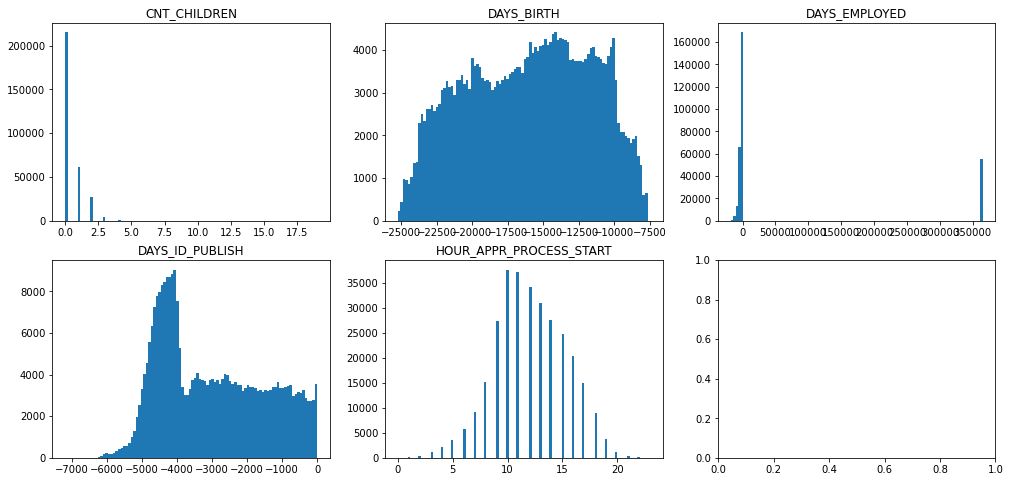

In [8]:
# split features based on whether they are BOOL but entered as 1,0
# remove TARGET and ID for EDA

# remove the FLAG columns they're not helpful here as they're equivalent to BOOLEANS
does_not_start_with = ('FLAG', 'REGION', 'REG_CITY', 'REG_REGION', 'LIVE_REGION', 'LIVE_CITY')

# save out the columns that are treated like BOOLs
bool_as_int_columns = [x for x in integer_columns if x.startswith(does_not_start_with)]
integer_columns = [x for x in integer_columns if not x.startswith(does_not_start_with)]



# also remove TARGET and ID 
others_to_remove = ['TARGET', 'SK_ID_CURR']
integer_columns = [i for i in integer_columns if i not in others_to_remove]
integer_columns


# visualize
num_feature_plots(df, integer_columns)#plot_triaxes(df, integer_columns)

In [9]:
df[integer_columns].describe()

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START
count,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000
mean,0.4171,-16036.9951,63815.0459,-2994.2024,12.0634
std,0.7221,4363.9886,141275.7665,1509.4504,3.2658
min,0.0000,-25229.0000,-17912.0000,-7197.0000,0.0000
25%,0.0000,-19682.0000,-2760.0000,-4299.0000,10.0000
50%,0.0000,-15750.0000,-1213.0000,-3254.0000,12.0000
75%,1.0000,-12413.0000,-289.0000,-1720.0000,14.0000
max,19.0000,-7489.0000,365243.0000,0.0000,23.0000


In [10]:
# remove observations with anomalous data
df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED'] == 365243
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})
df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED_ANOM'].astype(int)

# now check the max
print("max days employed: ", df.DAYS_EMPLOYED.max())

max days employed:  0


In [11]:
def corr_heatmap(selected_columns):
    '''Correlation heatmap with specific columns vs TARGET'''
    corr_col_list = copy.deepcopy(selected_columns)
    corr_col_list.insert(0,'TARGET')

    cm = np.corrcoef(df[corr_col_list].values.T)
    
    # set figsize dynamically
    f_size = len(selected_columns)

    f, ax = plt.subplots(figsize =(f_size, f_size)) 

    sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
        linewidths = 0.1, yticklabels = corr_col_list,  
                          xticklabels = corr_col_list) 

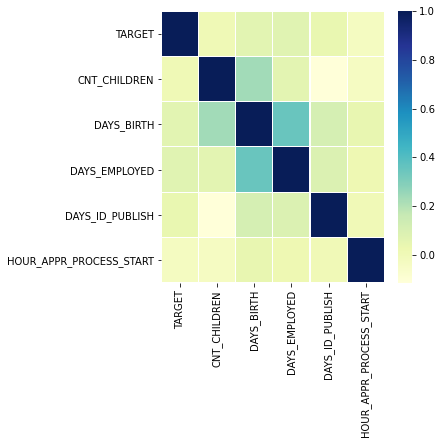

In [12]:
# run a correlation
corr_heatmap(integer_columns)


Children (```CNT_CHILDREN```) and Age (```DAYS_BIRTH```) are the most correlated with ```TARGET```.

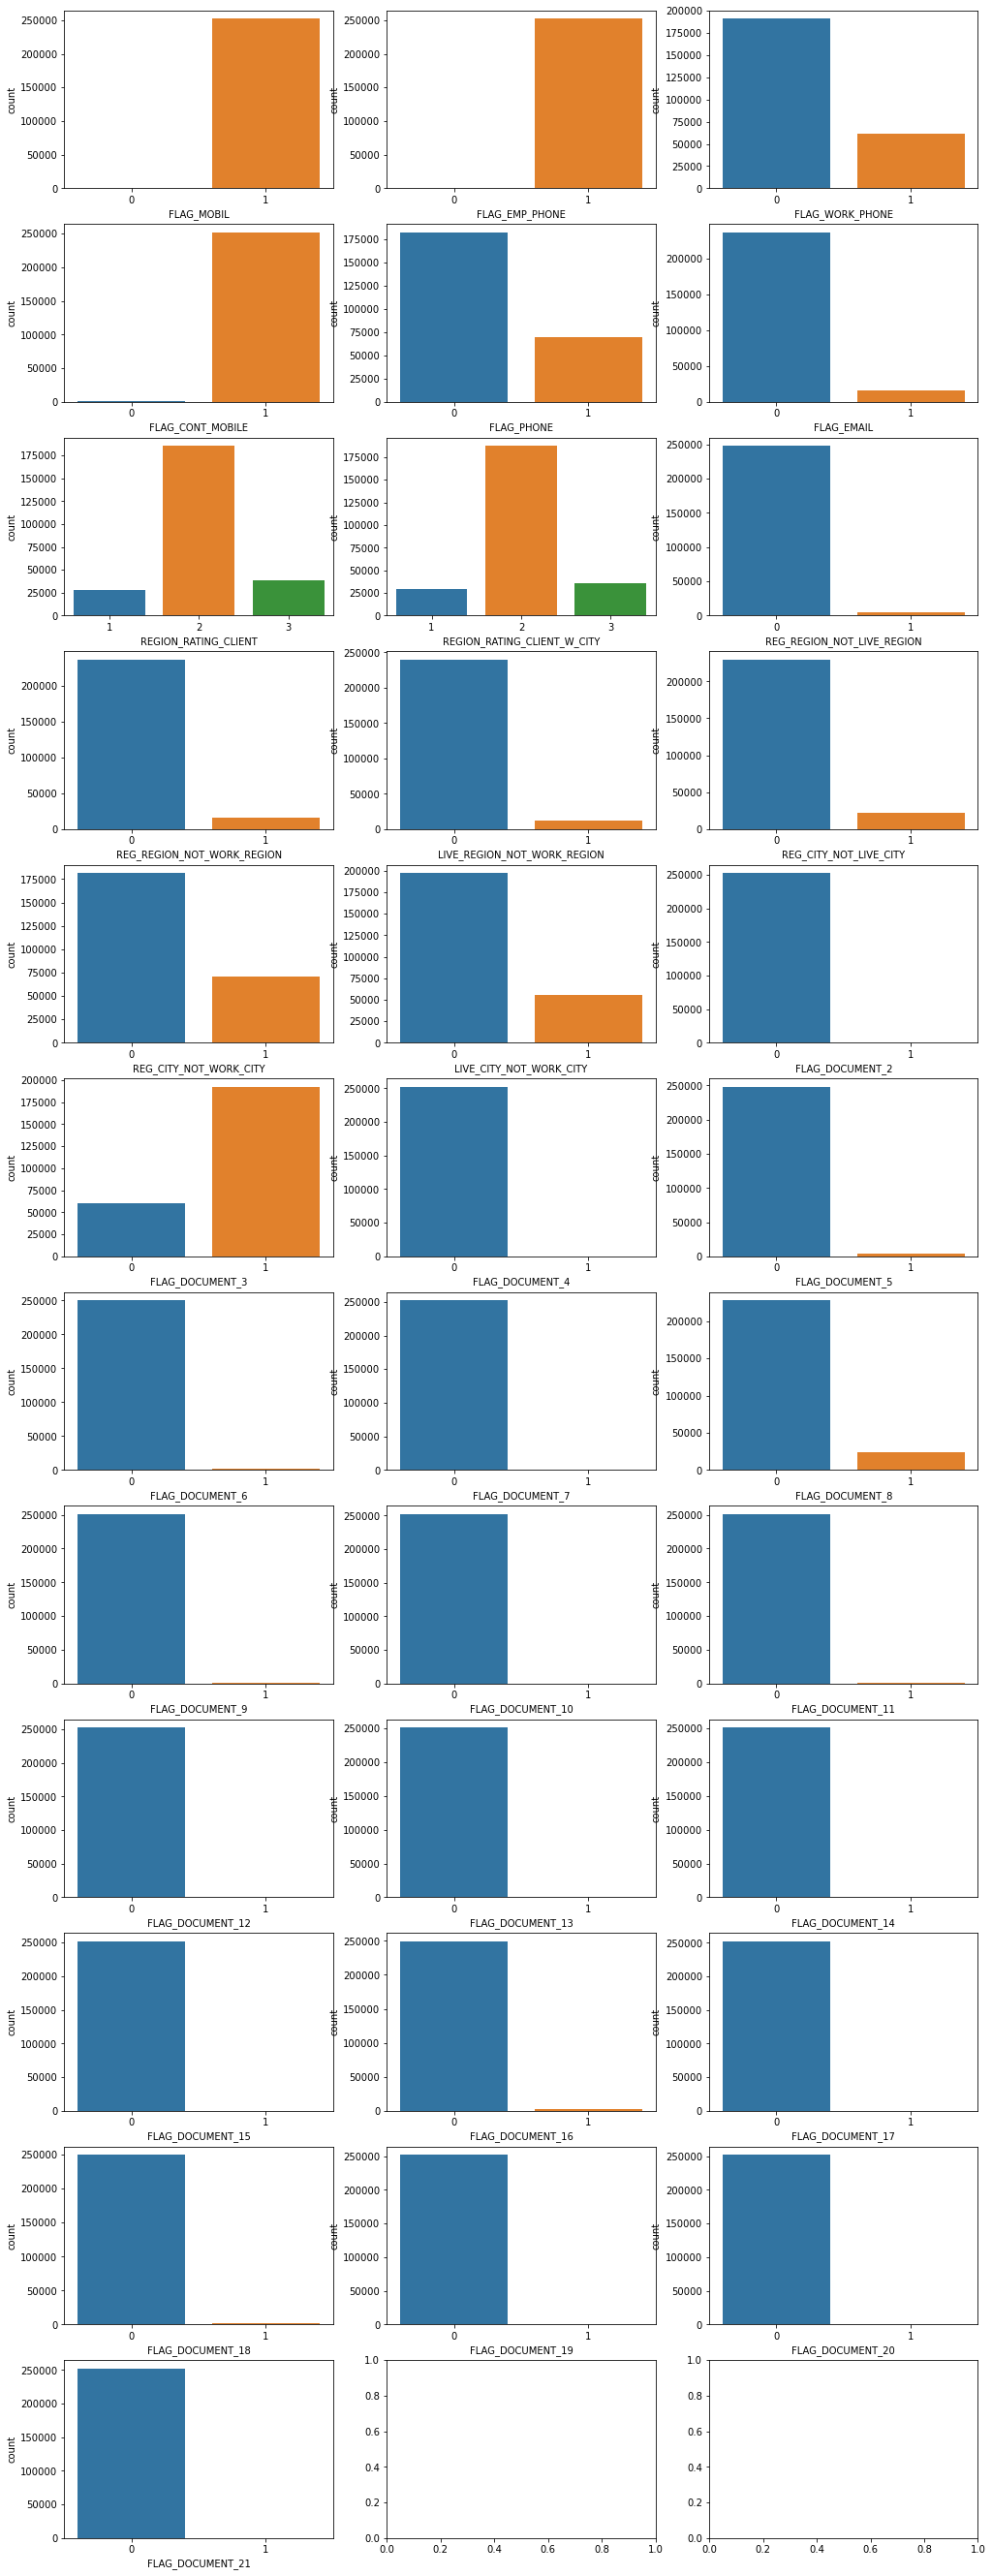

In [13]:
# now combine check out the BOOL features removed above for visualization
categorical_feature_plots(df,bool_as_int_columns)


## float features

In [14]:
float_columns = df.select_dtypes(include=['float64']).columns 

print("There are %s float features"%(float_columns.shape))
print(float_columns)
df[float_columns].describe()

There are 65 float features
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMON

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,252137.0000,252137.0000,252125.0000,251881.0000,252137.0000,252137.0000,94413.0000,252135.0000,121276.0000,251633.0000,...,251288.0000,251288.0000,251288.0000,252136.0000,218281.0000,218281.0000,218281.0000,218281.0000,218281.0000,218281.0000
mean,175914.0708,611398.4576,27812.3252,549405.6682,0.0209,-4635.4308,11.9502,2.2525,0.4819,0.5161,...,0.1399,1.3987,0.0977,-971.0386,0.0066,0.0070,0.0341,0.2820,0.2598,1.8563
std,258851.5877,406527.1999,14647.7591,373268.5346,0.0139,3252.1692,11.9820,0.9421,0.2055,0.1899,...,0.4419,2.3785,0.3581,827.3053,0.0851,0.1110,0.2028,0.9484,0.8237,1.8263
min,25650.0000,45000.0000,1980.0000,40500.0000,0.0003,-22928.0000,0.0000,1.0000,0.0146,0.0000,...,0.0000,0.0000,0.0000,-4292.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,112500.0000,277969.5000,17073.0000,247500.0000,0.0100,-6952.0000,5.0000,2.0000,0.3190,0.3983,...,0.0000,0.0000,0.0000,-1578.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,157500.0000,521280.0000,25834.5000,450000.0000,0.0188,-4265.0000,9.0000,2.0000,0.4809,0.5671,...,0.0000,0.0000,0.0000,-763.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,211500.0000,829224.0000,35617.5000,693000.0000,0.0287,-1845.0000,15.0000,3.0000,0.6450,0.6639,...,0.0000,2.0000,0.0000,-288.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
max,117000000.0000,4050000.0000,258025.5000,4050000.0000,0.0725,0.0000,91.0000,20.0000,0.9444,0.8550,...,34.0000,344.0000,24.0000,0.0000,4.0000,9.0000,8.0000,27.0000,261.0000,23.0000


Bureau-related features:  6
Remaining float features:  59


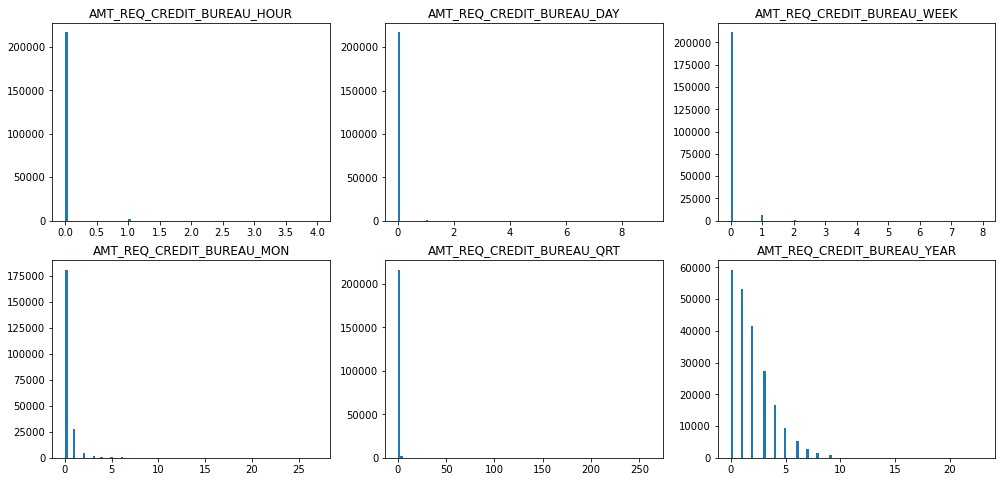

In [15]:
# split up the features a bit to make visual review easier
# look at the Bureau-related features and EXT_SOURCE separately
bureau_related = [x for x in float_columns if x.startswith('AMT_REQ')]
remaining_float = [i for i in float_columns if i not in bureau_related]

print("Bureau-related features: ", len(bureau_related))
print("Remaining float features: ", len(remaining_float))

num_feature_plots(df, bureau_related)

looks like the ```AMT_REQ_CREDIT_BUREAU_YEAR``` has the most variance. If the the others are sparse, consider removing

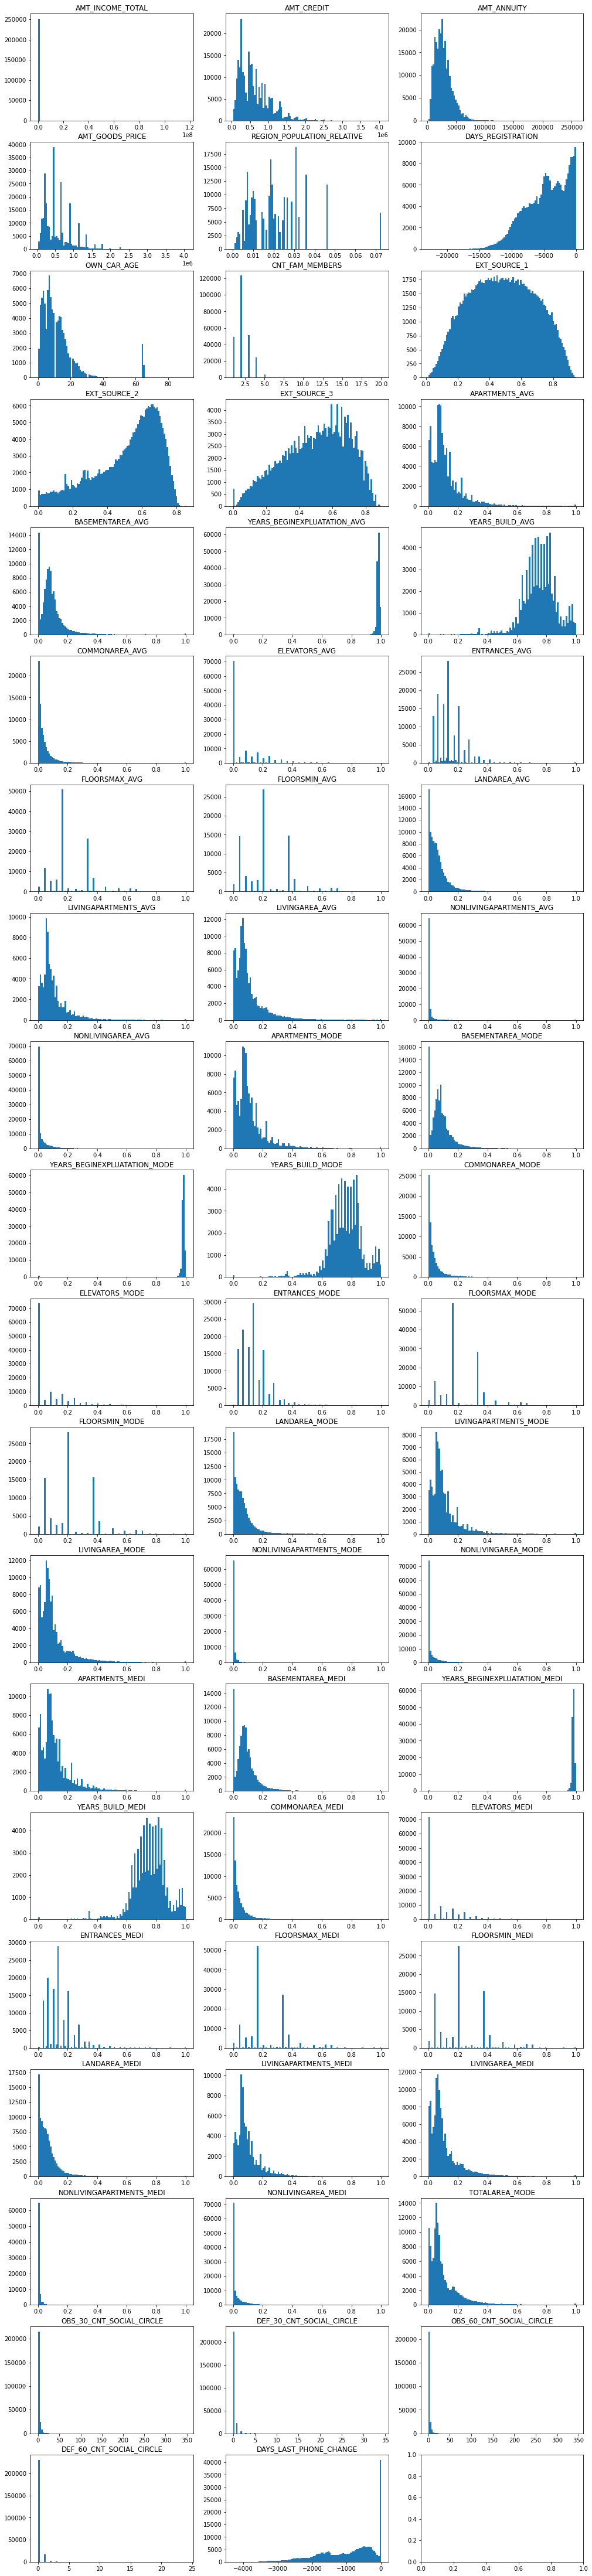

In [16]:
num_feature_plots(df, remaining_float)

<AxesSubplot:>

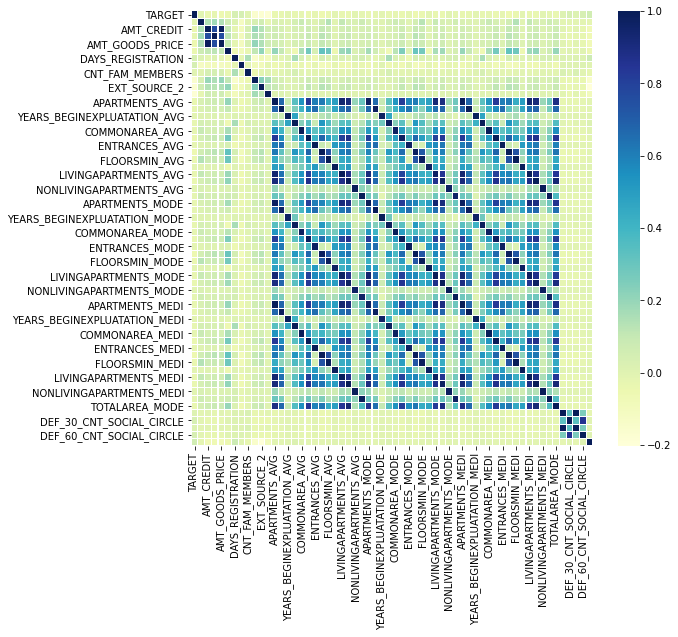

In [17]:
corr_col_list = copy.deepcopy(remaining_float)
corr_col_list.insert(0,'TARGET')

df_corr = df[corr_col_list].corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(df_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

There are correlations amongst variables, particularly those describing the real estate asset. There are also some with ```AMT_GOODS_PRICE```. 

## categorical features

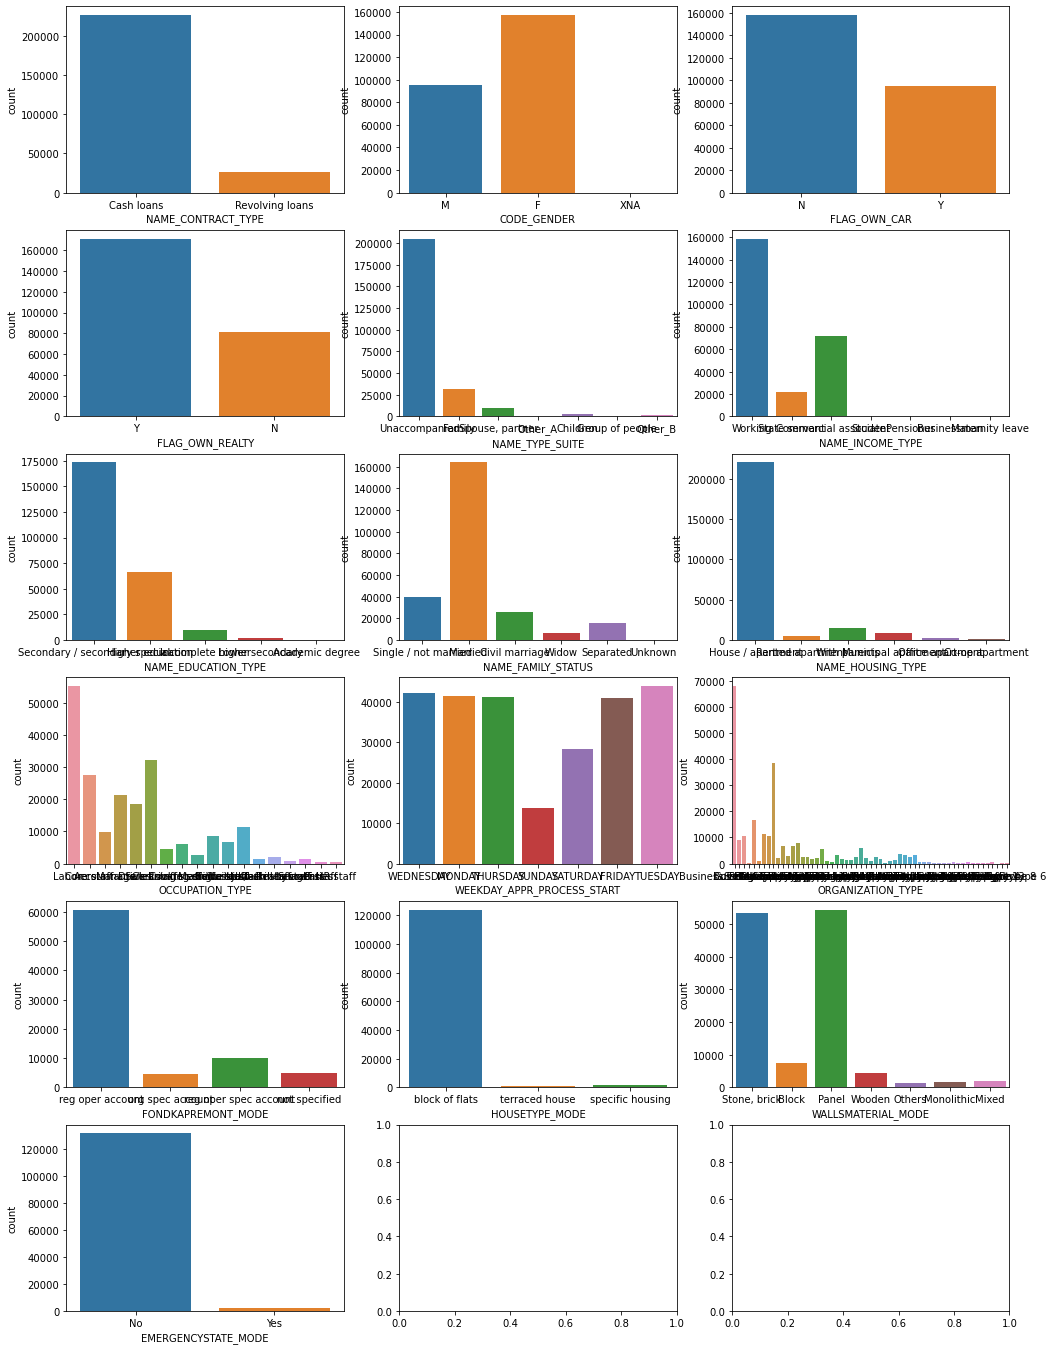

In [18]:
cat_columns = df.select_dtypes(include=['object', 'category']).columns 
categorical_feature_plots(df,cat_columns)

In [19]:
# look at categorical variables with the greatest number of unique levels
df[cat_columns].describe().T.sort_values(by='unique', ascending=False)


,count,unique,top,freq
ORGANIZATION_TYPE,252137,57,Business Entity Type 3,67992
OCCUPATION_TYPE,211118,18,Laborers,55186
NAME_TYPE_SUITE,251041,7,Unaccompanied,205018
NAME_INCOME_TYPE,252137,7,Working,158774
WEEKDAY_APPR_PROCESS_START,252137,7,TUESDAY,43948
WALLSMATERIAL_MODE,124530,7,Panel,54339
NAME_FAMILY_STATUS,252137,6,Married,163914
NAME_HOUSING_TYPE,252137,6,House / apartment,220483
NAME_EDUCATION_TYPE,252137,5,Secondary / secondary special,173286
FONDKAPREMONT_MODE,80055,4,reg oper account,60737


Looks like ```ORGANIZATION_TYPE``` has a large number of levels and lots of missing data. May be a good candidate for removing.

## Bureau Data

In [20]:
int_features = bureau.iloc[:, 2:].select_dtypes('int64').columns.values
float_features = bureau.iloc[:, 2:].select_dtypes('float64').columns.values
str_features = bureau.iloc[:, 2:].select_dtypes('O').columns.values

print('# of integer features:', len(int_features))
print('# of float features:', len(float_features))
print('# of str features:', len(str_features))

# of integer features: 4
# of float features: 8
# of str features: 3


In [22]:
bureau.iloc[:, 2:].select_dtypes('O').describe()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


In [21]:
for i in str_features:
    print(bureau[i].value_counts(dropna=False) / len(bureau) * 100)

Closed     62.8790
Active     36.7395
Sold        0.3803
Bad debt    0.0012
Name: CREDIT_ACTIVE, dtype: float64
currency 1   99.9180
currency 2    0.0713
currency 3    0.0101
currency 4    0.0006
Name: CREDIT_CURRENCY, dtype: float64
Consumer credit                                72.9197
Credit card                                    23.4321
Car loan                                        1.6132
Mortgage                                        1.0715
Microloan                                       0.7232
Loan for business development                   0.1151
Another type of loan                            0.0593
Unknown type of loan                            0.0323
Loan for working capital replenishment          0.0273
Cash loan (non-earmarked)                       0.0033
Real estate loan                                0.0016
Loan for the purchase of equipment              0.0011
Loan for purchase of shares (margin lending)    0.0002
Interbank credit                                0.0

Active and bad debt will be useful flag for feature engineering later. 

In [30]:
bureau.iloc[:, 2:].select_dtypes('float64').describe()

,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,603486.0000,1082775.0000,591940.0000,1716415.0000,1450341.0000,1124297.0000,1716428.0000,1716411.0000,489637.0000
mean,3106.7260,-1017.4371,3825.4177,354994.5919,137926.1187,6238.8775,37.9128,-593.7546,15712.7577
std,7384.7634,714.0106,206031.6062,1149811.3440,679233.8310,45022.3336,5937.6500,720.7481,325826.9491
min,0.0000,-42023.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-41947.0000,0.0000
25%,323.0000,-1489.0000,0.0000,51300.0000,0.0000,0.0000,0.0000,-908.0000,0.0000
50%,790.0000,-897.0000,0.0000,125518.5000,0.0000,0.0000,0.0000,-395.0000,0.0000
75%,1386.0000,-425.0000,0.0000,315000.0000,41400.0000,0.0000,0.0000,-33.0000,13500.0000
max,31199.0000,0.0000,115987185.0000,585000000.0000,170100000.0000,4705600.3200,3756681.0000,0.0000,118453423.5000


Remove nagative values DAYS_CREDIT_ENDDATE because we don't need duration of **nonactive loans** and we already have  DAYS_ENDDATE_FACT for closed loans.

Remove negative amounts for all of these AMT data. 

In [24]:
import warnings
warnings.filterwarnings('ignore')
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_OVERDUE'][bureau['AMT_CREDIT_SUM_OVERDUE'] < 0] = np.nan
bureau['AMT_ANNUITY'][bureau['AMT_ANNUITY'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_LIMIT'][bureau['AMT_CREDIT_SUM_LIMIT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_DEBT'][bureau['AMT_CREDIT_SUM_DEBT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM'][bureau['AMT_CREDIT_SUM'] < 0] = np.nan
bureau['AMT_CREDIT_MAX_OVERDUE'][bureau['AMT_CREDIT_MAX_OVERDUE'] < 0] = np.nan
print(bureau.iloc[:, 2:].select_dtypes('float64').describe())

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count          603486.0000       1082775.0000             591940.0000   
mean             3106.7260         -1017.4371               3825.4177   
std              7384.7634           714.0106             206031.6062   
min                 0.0000        -42023.0000                  0.0000   
25%               323.0000         -1489.0000                  0.0000   
50%               790.0000          -897.0000                  0.0000   
75%              1386.0000          -425.0000                  0.0000   
max             31199.0000             0.0000          115987185.0000   

       AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count    1716415.0000         1450341.0000          1124297.0000   
mean      354994.5919          137926.1187             6238.8775   
std      1149811.3440          679233.8310            45022.3336   
min            0.0000               0.0000                0.0000   
25

In [ ]:
print(bureau.iloc[:, 2:].select_dtypes('int64').describe())

Removed positive values for DAYS_CREDIT_UPDATE they don't make sense in our context. 

In [31]:
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > 0] = np.nan
bureau.iloc[:, 2:].select_dtypes('int64').describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG
count,1716428.0000,1716428.0000,1716428.0000
mean,-1142.1077,0.8182,0.0064
std,795.1649,36.5444,0.0962
min,-2922.0000,0.0000,0.0000
25%,-1666.0000,0.0000,0.0000
50%,-987.0000,0.0000,0.0000
75%,-474.0000,0.0000,0.0000
max,0.0000,2792.0000,9.0000


## Previous Applicaton Data

In [26]:
int_features = prev_app.iloc[:, 2:].select_dtypes('int64').columns.values
float_features = prev_app.iloc[:, 2:].select_dtypes('float64').columns.values
str_features = prev_app.iloc[:, 2:].select_dtypes('O').columns.values

print('# of integer features:', len(int_features))
print('# of float features:', len(float_features))
print('# of str features:', len(str_features))

# of integer features: 4
# of float features: 15
# of str features: 16


In [27]:
for i in str_features:
    print(prev_app[i].value_counts(dropna=False) / len(bureau) * 100)

Cash loans        43.5528
Consumer loans    42.4807
Revolving loans   11.2538
XNA                0.0202
Name: NAME_CONTRACT_TYPE, dtype: float64
TUESDAY     14.8633
WEDNESDAY   14.8570
MONDAY      14.7724
FRIDAY      14.6844
THURSDAY    14.5126
SATURDAY    14.0193
SUNDAY       9.5985
Name: WEEKDAY_APPR_PROCESS_START, dtype: float64
Y   96.8138
N    0.4938
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: float64
XAP                                53.7547
XNA                                39.4959
Repairs                             1.3846
Other                               0.9093
Urgent needs                        0.4901
Buying a used car                   0.1683
Building a house or an annex        0.1569
Everyday expenses                   0.1408
Medicine                            0.1267
Payments on other loans             0.1125
Education                           0.0916
Journey                             0.0722
Purchase of electronic equipment    0.0618
Buying a new car                 

Approved, Refused, High/Low Interest and New and Repeat will be interesting flag to use for feature engineering later

In [32]:
prev_app.iloc[:, 2:].select_dtypes('int64').describe()

,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA
count,1670214.0000,1670214.0000,1670214.0000,1670214.0000
mean,12.4842,0.9965,-880.6797,313.9511
std,3.3340,0.0593,779.0997,7127.4435
min,0.0000,0.0000,-2922.0000,-1.0000
25%,10.0000,1.0000,-1300.0000,-1.0000
50%,12.0000,1.0000,-581.0000,3.0000
75%,15.0000,1.0000,-280.0000,82.0000
max,23.0000,1.0000,-1.0000,4000000.0000


**sellerplace_area shouldn't be negative**

In [33]:
prev_app['SELLERPLACE_AREA'][prev_app['SELLERPLACE_AREA'] < 0] = np.nan

In [34]:
prev_app.iloc[:, 2:].select_dtypes('float64').describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1297979.0000,1670214.0000,1670213.0000,774370.0000,1284699.0000,774370.0000,5951.0000,5951.0000,907539.0000,1297984.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000
mean,15955.1207,175233.8604,196114.0212,6697.4021,227847.2793,0.0796,0.1884,0.7735,578.6288,16.0541,342209.8550,13826.2693,33767.7741,76582.4031,81992.3438,0.3326
std,14782.1373,292779.7624,318574.6165,20921.4954,315396.5579,0.1078,0.0877,0.1009,9661.1913,14.5673,88916.1158,72444.8697,106857.0348,149647.4151,153303.5167,0.4711
min,0.0000,0.0000,0.0000,-0.9000,0.0000,-0.0000,0.0348,0.3732,0.0000,0.0000,-2922.0000,-2892.0000,-2801.0000,-2889.0000,-2874.0000,0.0000
25%,6321.7800,18720.0000,24160.5000,0.0000,50841.0000,0.0000,0.1607,0.7156,25.0000,6.0000,365243.0000,-1628.0000,-1242.0000,-1314.0000,-1270.0000,0.0000
50%,11250.0000,71046.0000,80541.0000,1638.0000,112320.0000,0.0516,0.1891,0.8351,65.0000,12.0000,365243.0000,-831.0000,-361.0000,-537.0000,-499.0000,0.0000
75%,20658.4200,180360.0000,216418.5000,7740.0000,234000.0000,0.1089,0.1933,0.8525,351.0000,24.0000,365243.0000,-411.0000,129.0000,-74.0000,-44.0000,1.0000
max,418058.1450,6905160.0000,6905160.0000,3060045.0000,6905160.0000,1.0000,1.0000,1.0000,4000000.0000,84.0000,365243.0000,365243.0000,365243.0000,365243.0000,365243.0000,1.0000


**amt_down_payment, shouldn't be negative. DAYS_ fields shouldn't be positive**

In [35]:
prev_app['AMT_DOWN_PAYMENT'][prev_app['AMT_DOWN_PAYMENT'] < 0] = np.nan
prev_app['DAYS_FIRST_DRAWING'][prev_app['DAYS_FIRST_DRAWING'] > 0] = np.nan
prev_app['DAYS_FIRST_DUE'][prev_app['DAYS_FIRST_DUE'] > 0] = np.nan
prev_app['DAYS_LAST_DUE_1ST_VERSION'][prev_app['DAYS_LAST_DUE_1ST_VERSION'] > 0] = np.nan
prev_app['DAYS_LAST_DUE'][prev_app['DAYS_LAST_DUE'] > 0] = np.nan
prev_app['DAYS_TERMINATION'][prev_app['DAYS_TERMINATION'] > 0] = np.nan